In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "AMZN" # MDRX is shortable 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime(2024, 5, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,AMZN,32.81,32.89,31.38,31.85,192327900.0,137283.0,31.97
2016-01-05 05:00:00+00:00,AMZN,32.34,32.35,31.38,31.69,119738940.0,72594.0,31.75
2016-01-06 05:00:00+00:00,AMZN,31.10,31.99,31.02,31.63,109533180.0,67908.0,31.58
2016-01-07 05:00:00+00:00,AMZN,31.09,31.50,30.26,30.40,145573100.0,92501.0,30.81
2016-01-08 05:00:00+00:00,AMZN,30.98,31.21,30.30,30.35,114584160.0,71586.0,30.74


<Axes: xlabel='timestamp'>

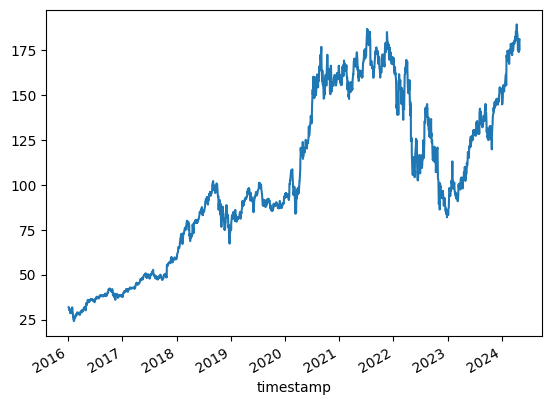

In [2]:
data["close"].plot()

## making a signal as a category 


In [3]:
data["open_deri"] = np.gradient(data["open"].values, np.array(range(0, len(data))))
data["open_deri"]

timestamp
2016-01-04 05:00:00+00:00   -0.4700
2016-01-05 05:00:00+00:00   -0.8550
2016-01-06 05:00:00+00:00   -0.6250
2016-01-07 05:00:00+00:00   -0.0600
2016-01-08 05:00:00+00:00   -0.2350
                              ...  
2024-04-24 04:00:00+00:00   -4.2000
2024-04-25 04:00:00+00:00   -1.0725
2024-04-26 04:00:00+00:00    6.5350
2024-04-29 04:00:00+00:00    1.6475
2024-04-30 04:00:00+00:00   -1.6600
Name: open_deri, Length: 2095, dtype: float64

<Axes: xlabel='timestamp'>

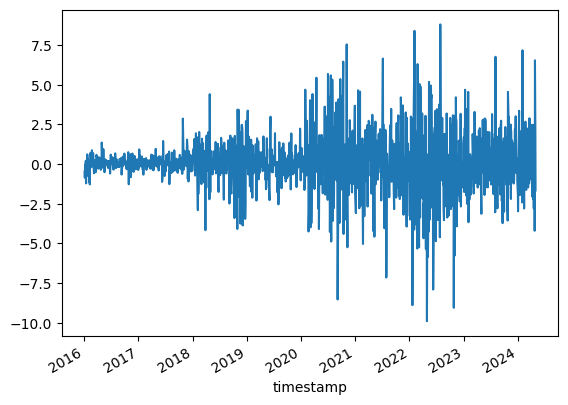

In [4]:
data["open_deri"].plot()

In [5]:
neutral = 0
sell = 1
buy = 2

In [6]:
data["signal"] = neutral# NEUTRAL
data.loc[data["open_deri"] > 0.8, "signal"] = buy # BUY
data.loc[data["open_deri"] < -0.8, "signal"] = sell # SELL
data["signal"]

timestamp
2016-01-04 05:00:00+00:00    0
2016-01-05 05:00:00+00:00    1
2016-01-06 05:00:00+00:00    0
2016-01-07 05:00:00+00:00    0
2016-01-08 05:00:00+00:00    0
                            ..
2024-04-24 04:00:00+00:00    1
2024-04-25 04:00:00+00:00    1
2024-04-26 04:00:00+00:00    2
2024-04-29 04:00:00+00:00    2
2024-04-30 04:00:00+00:00    1
Name: signal, Length: 2095, dtype: int64

# making a model 

In [7]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

2095 1676 419


In [8]:
train_data.head()

,symbol,open,high,low,close,volume,trade_count,vwap,open_deri,signal
timestamp,,,,,,,,,,
2016-01-04 05:00:00+00:00,AMZN,32.81,32.89,31.38,31.85,192327900.0,137283.0,31.97,-0.470,0
2016-01-05 05:00:00+00:00,AMZN,32.34,32.35,31.38,31.69,119738940.0,72594.0,31.75,-0.855,1
2016-01-06 05:00:00+00:00,AMZN,31.10,31.99,31.02,31.63,109533180.0,67908.0,31.58,-0.625,0
2016-01-07 05:00:00+00:00,AMZN,31.09,31.50,30.26,30.40,145573100.0,92501.0,30.81,-0.060,0
2016-01-08 05:00:00+00:00,AMZN,30.98,31.21,30.30,30.35,114584160.0,71586.0,30.74,-0.235,0


<Axes: xlabel='timestamp'>

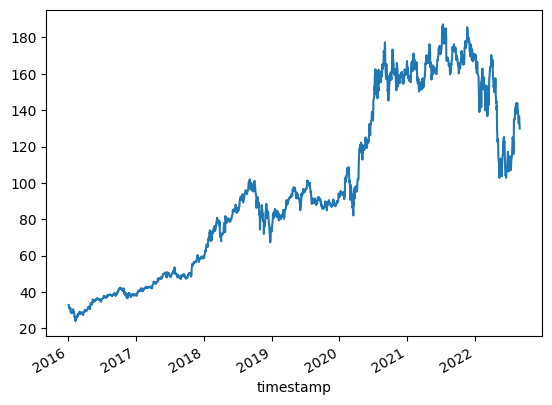

In [9]:
train_data["open"].plot()

In [10]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["signal"].values
X = train_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False).values
model = RandomForestClassifier(max_depth=2,random_state=0)
model.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

In [11]:
#model.predict(test_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False).values)
model.predict_proba(test_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False).values)

array([[0.31477427, 0.34266648, 0.34255925],
       [0.29397423, 0.3474757 , 0.35855006],
       [0.29397423, 0.3474757 , 0.35855006],
       ...,
       [0.31639459, 0.33427428, 0.34933113],
       [0.31639459, 0.33427428, 0.34933113],
       [0.28589234, 0.3440694 , 0.37003826]])

In [12]:
from sklearn.metrics import mean_squared_error
y_test = test_data["signal"].values
X_test = test_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False).values
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.298329355608592


## making it a strat 

In [13]:
from cira.strategy import Strategy
from numpy import ndarray
from pandas import DataFrame


class Clf(Strategy):
    def __init__(self, model:RandomForestClassifier, risk=0.02) -> None:
        super().__init__("Clf")
        self.model = model 
        self.risk = risk
        self.sizeings = {"position_size":[]}

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float) -> ndarray:
        pred = list(self.model.predict_proba(feature_data.values)[-1])
        portfolio_change = np.array([self.size(pred, prices.values.tolist()[-1][0], cash)])
        self.sizeings["position_size"].append(int(portfolio[-1]) + portfolio_change)
        #self.sizeings["position_size"].append(portfolio_change)
        return portfolio_change

    def size(self, pred:list, entry_price:float, cash:float) -> int:
        if np.argmax(pred) == neutral:
          return 0
        if pred[buy] < pred[sell]: 
            prc_alc = (pred[sell] - pred[buy])**(1-self.risk)
            prc_alc *= -1
        else: 
            prc_alc = (pred[buy] - pred[sell])**(1-self.risk)
        
        return int((cash * prc_alc) // entry_price)


In [14]:
strat = Clf(model, risk=0.5)
featrues = test_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False)
prices = test_data["open"].to_frame()
strat.iterate(featrues, prices , np.array([0]), 10_000)

array([8])

<Axes: xlabel='timestamp'>

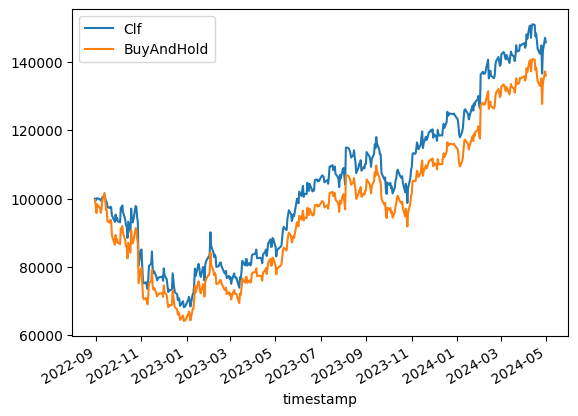

In [24]:
from cira.strategy import back_test_against_buy_and_hold as back_test

back_test(strat, featrues, prices, 100_000).plot()

<Axes: xlabel='timestamp'>

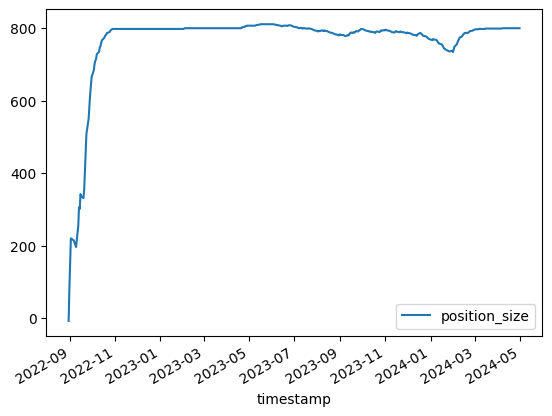

In [27]:
strat.sizeings["position_size"] = np.array(strat.sizeings["position_size"])
pd.DataFrame(strat.sizeings, index=test_data.index).plot()